# Imports

In [69]:
# ! pip install torch torchvision matplotlib numpy ffmpeg

In [70]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.auto import tqdm
import numpy as np
import random

from IPython.display import HTML, Image
from IPython import display

# Define the model

## Encoder Layer (based of DAC paper)

In [71]:
class Encoder(nn.Module):
    def __init__(
            self,
            input_size=784,
            embedding_size=10
    ):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            # Input layer
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Tanh(),

            # Hidden layer
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Tanh(),

            # Hidden layer
            nn.Linear(128, 32),
            nn.Tanh(),

            # getting embedding
            nn.Linear(32, embedding_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded



## Decoder Layer (based of DAC paper)

In [72]:
class Decoder(nn.Module):
    def __init__(
            self,
            embedding_size=10,
            output_size=784
    ):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # Input layer
            nn.Linear(embedding_size, 32),
            nn.Tanh(),

            # Hidden layer
            nn.Linear(32, 128),
            nn.Tanh(),

            # Hidden layer
            nn.Linear(128, 512),
            nn.Tanh(),

            # getting decoded
            nn.Linear(512, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        decoded = self.decoder(x)
        return decoded

## AutoEncoder Model

In [73]:
class AutoEncoder(nn.Module):
    def __init__(
            self,
            dimension_size=784,
            embedding_size=10,
    ):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(dimension_size, embedding_size)
        self.decoder = Decoder(embedding_size, dimension_size)

    def get_embedding(self, x):
        encoded = self.encoder(x)
        return encoded

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# MNIST dataset

## Load and normalize MNIST dataset

In [74]:
scale = torchvision.transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    scale
])

train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

## Explore dataset

MNIST Train Split Samples (seed = 2)


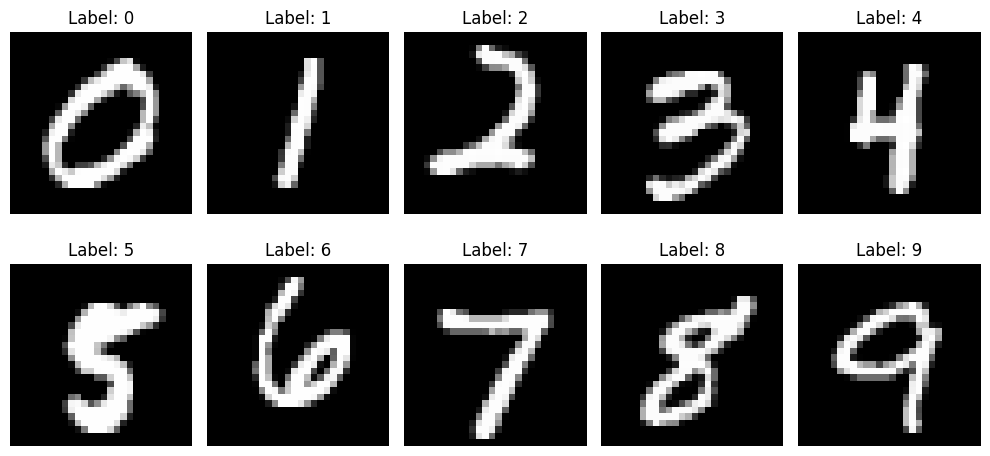

In [75]:
SEED = 2

np.random.seed(SEED)
print(f"MNIST Train Split Samples (seed = {SEED})")

# Create a new figure
plt.figure(figsize=(10, 5))

# Initialize variables to track whether a sample from each category has been found
found_samples = {i: False for i in range(10)}

# Loop through the dataset to find one sample from each category
while not all(found_samples.values()):
    idx = np.random.randint(0, len(train_set))
    image , label = train_set[idx]
    if not found_samples[label]:
        # Plot the image
        plt.subplot(2, 5, label + 1)  # Adjusting index (starting from 1)
        plt.imshow(image.squeeze(), cmap='gray')  # Assuming grayscale images
        plt.title(f'Label: {label}')
        plt.axis('off')
        found_samples[label] = True

# Show the plot
plt.tight_layout()
plt.show()

# Train AutoEncoder Model

## Util functions

In [76]:
@torch.no_grad()
def model_eval(model, data_loader):
    test_loss = 0
    test_metric = 0
    test_total = 0
    for images, labels in data_loader:
        # Prepare
        images = images.view(images.shape[0], -1)

        # Forward
        outputs = model(images)

        # Loss
        loss = criterion(outputs, images)
        metric_value = metric(outputs, images)

        # Statistics
        test_loss += loss.item()
        test_total += images.shape[0]
        test_metric += metric_value.item()

    return (test_loss/test_total), (test_metric/test_total)


In [77]:
def capture_images(seed, dataset):
    captured = [False] * 10
    np.random.seed(seed)

    images = [False] * 10

    while not all(captured):
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]

        if captured[label]:
            continue
        captured[label] = True

        images[label] = image.view(image.shape[0], -1)

    return images

In [78]:
def plot_org_constructed_plot(model, org_images, prompt=""):
    fig = plt.figure(figsize=(20, 6))
    if prompt:
        plt.title(prompt)

    for label, image in enumerate(org_images):
        ax = plt.subplot(2, 10, label + 1)
        plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'original: {label}', loc='center')


        ax = plt.subplot(2, 10, label + 11)
        plt.imshow(model(image).detach().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'constructed: {label}', loc='center')

    return fig


In [79]:
def compute_mask(dataset, seed=41, sample_count=2000):
    random.seed(seed)
    samples = random.choices(dataset, k=sample_count)
    image_set = {l: [] for l in range(10)}
    for img, l in samples:
        img = torch.squeeze(img)
        image_set[l].append(img)

    image_set = {l: torch.tensor(np.array(image_set[l])) for l in image_set}
    contradicted = torch.zeros((28, 28))
    entailed = torch.zeros((28, 28))
    contradicted_length = 0
    entailed_length = 0

    def concatenate(exclude):
        all_images_set = None
        for l in image_set:
            if l == exclude:
                continue
            if all_images_set is None:
                all_images_set = image_set[l]
            else:
                all_images_set = torch.cat((all_images_set, image_set[l]))
        return all_images_set


    for c_label in range(10):
        n = np.shape(image_set[c_label])[0]
        entailed_length += n * (n-1)
        contra_set = concatenate(c_label)
        contradicted_length += n * np.shape(contra_set)[0]
        for idx, img in enumerate(image_set[c_label]):
            # Internal
            t = torch.cat((image_set[c_label][:idx, :, :], image_set[c_label][idx + 1:, :, :]), dim=0)
            t = torch.exp(-torch.pow(t - img, 2))
            entailed = entailed + torch.sum(t, dim=0)

            # External
            t = contra_set
            t = torch.exp(-torch.pow(t - img, 2))
            t = 1 - t
            contradicted = contradicted + torch.sum(t, dim=0)

    entailed = entailed / entailed_length
    contradicted = contradicted / contradicted_length

    W_i = entailed * contradicted

    return W_i


## Configs

In [80]:
LearningRate = 3e-3
EPOCHS = 200
BatchSize = 32
AnimationFrequencyDiv = 25
WeightDecay = 8e-3
WeightMaskSampleSize = 1000

## Create an instance of our autoencoder with dimension size 784 and embedding size 10

In [81]:
autoencoder = AutoEncoder(dimension_size=784, embedding_size=10)

print(autoencoder)


AutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Tanh()
      (3): Linear(in_features=512, out_features=128, bias=True)
      (4): ReLU()
      (5): Tanh()
      (6): Linear(in_features=128, out_features=32, bias=True)
      (7): Tanh()
      (8): Linear(in_features=32, out_features=10, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=512, bias=True)
      (5): Tanh()
      (6): Linear(in_features=512, out_features=784, bias=True)
      (7): Sigmoid()
    )
  )
)


## Create dataloaders

In [82]:
train_loader = DataLoader(train_set, batch_size=BatchSize, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BatchSize, shuffle=False)

## Prepare training config

### Create Loss function

#### Compute mask

Please pay attention that we can create mask ($W_i$) with different samples instead of 1000 from the `DAC` paper (configurable using config above)

1. np.shape(W_i) = torch.Size([28, 28])


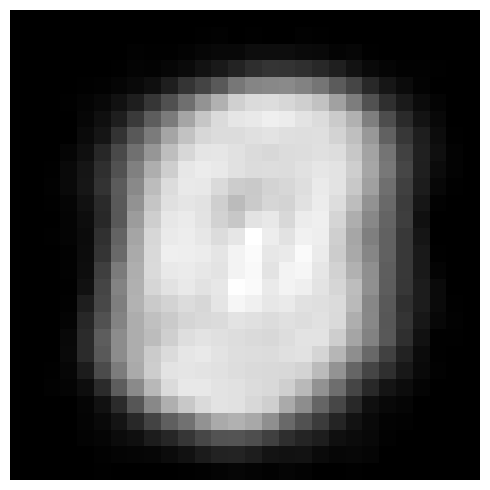

2. np.shape(W_i) = torch.Size([784])


In [83]:
W_i = compute_mask(train_set, sample_count=WeightMaskSampleSize)
W_i = W_i.squeeze()
print(f"1. {np.shape(W_i) = }")

plt.figure(figsize=(5, 5))
plt.imshow(W_i, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

W_i = W_i.view(-1)
print(f"2. {np.shape(W_i) = }")

#### Create loss class

In [84]:
class CMSELoss(nn.Module):
    def __init__(self, w_i):
        super(CMSELoss, self).__init__()
        self.w_i = w_i

    def forward(self, outputs, labels):
        return torch.sum(torch.mean(self.w_i * torch.pow(labels-outputs, 2), dim=0))


In [85]:
class Loss(nn.Module):
    def __init__(self, w_i, beta=1e-5):
        super(Loss, self).__init__()

        self.cmse_loss = CMSELoss(w_i)
        self.mse_loss = nn.MSELoss()
        self.beta = beta

    def forward(self, outputs, labels):
        return self.cmse_loss(outputs, labels) + \
            (self.beta * np.shape(outputs)[0] * self.mse_loss(outputs, labels))


#### Initialize Configure

In [86]:
criterion = Loss(W_i, beta=1e-5)
metric = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LearningRate, weight_decay=WeightDecay)
random.seed(SEED)

## Setup reports

In [87]:
train_loss_list = []
train_metric_list = []

test_loss_list = []
test_metric_list = []

animation_images = capture_images(19, test_set)
animation_frames = []

trained_epoch = 0

## Train model

In [88]:
for epoch in range(EPOCHS):
    if trained_epoch % AnimationFrequencyDiv == 0:
        fig = plot_org_constructed_plot(autoencoder, animation_images, prompt=f"EPOCH {trained_epoch}")
        animation_frames.append(fig)
        plt.close()

    train_loss = 0
    train_metric = 0
    train_total = 0
    trained_epoch += 1
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()

        outputs = autoencoder(images)

        loss = criterion(outputs, images)

        metric_value = metric(outputs, images)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_metric += metric_value.item()
        train_total += images.shape[0]

    print(f"Epoch {trained_epoch} - Train Loss: {train_loss/train_total:.4f}, Train Metric: {train_metric/train_total:.4f}")

    train_loss_list.append(train_loss/train_total)
    train_metric_list.append(train_metric/train_total)

    test_loss, test_metric = model_eval(autoencoder, test_loader)
    test_loss_list.append(test_loss)
    test_metric_list.append(test_metric)


Epoch 1 - Train Loss: 0.1921, Train Metric: 0.0014
Epoch 2 - Train Loss: 0.1434, Train Metric: 0.0010
Epoch 3 - Train Loss: 0.1324, Train Metric: 0.0009
Epoch 4 - Train Loss: 0.1234, Train Metric: 0.0009
Epoch 5 - Train Loss: 0.1163, Train Metric: 0.0008
Epoch 6 - Train Loss: 0.1132, Train Metric: 0.0008
Epoch 7 - Train Loss: 0.1107, Train Metric: 0.0008
Epoch 8 - Train Loss: 0.1085, Train Metric: 0.0008
Epoch 9 - Train Loss: 0.1065, Train Metric: 0.0008
Epoch 10 - Train Loss: 0.1049, Train Metric: 0.0008
Epoch 11 - Train Loss: 0.1035, Train Metric: 0.0007
Epoch 12 - Train Loss: 0.1027, Train Metric: 0.0007
Epoch 13 - Train Loss: 0.1011, Train Metric: 0.0007
Epoch 14 - Train Loss: 0.0995, Train Metric: 0.0007
Epoch 15 - Train Loss: 0.0978, Train Metric: 0.0007
Epoch 16 - Train Loss: 0.0970, Train Metric: 0.0007
Epoch 17 - Train Loss: 0.0964, Train Metric: 0.0007
Epoch 18 - Train Loss: 0.0953, Train Metric: 0.0007
Epoch 19 - Train Loss: 0.0948, Train Metric: 0.0007
Epoch 20 - Train Loss

## Evaluate the model

In [89]:
test_loss, test_metric = model_eval(autoencoder, test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Metric: {test_metric:.4f}")

Test Loss: 0.0841, Test Metric: 0.0006


### Train K-Mean model

In [90]:
@torch.no_grad()
def get_embedding(data_loader, model=None):
    embeddings , label_set = None, None
    for idx, (images, labels) in enumerate(data_loader):
        images = images.view(images.shape[0], -1)
        if model is None:
            embedding = images
        else:
            embedding = model.get_embedding(images)
        if idx == 0:
            embeddings = embedding
            label_set = labels
        else:
            embeddings = torch.cat((embeddings, embedding), dim=0)
            label_set = torch.cat((label_set, labels), dim=0)

    return embeddings , label_set

In [91]:
embeddings , label_set = get_embedding(train_loader, autoencoder)

In [92]:
embed_kmeans = KMeans(n_clusters=10, init="k-means++", n_init="auto", random_state=SEED)
embed_kmeans.fit(embeddings)

KMeans(n_clusters=10, n_init='auto', random_state=2)

In [93]:
print(f"ARI score for Train data: {adjusted_rand_score(label_set, embed_kmeans.labels_):.5f}")

ARI score for Train data: 0.50371


## Evaluation

In [94]:
test_embeddings , test_label_set = get_embedding(test_loader, autoencoder)
embed_pred_clusters = embed_kmeans.predict(test_embeddings)
print(f"ARI score for Test data: {adjusted_rand_score(test_label_set, embed_pred_clusters):.5f}")


ARI score for Test data: 0.51804


# Use pure K-Means

In [95]:
img_train_embeddings , train_label_set = get_embedding(train_loader)
img_test_embeddings , test_label_set = get_embedding(test_loader)

pure_kmeans = KMeans(n_clusters=10, init="k-means++", n_init="auto", random_state=SEED)
pure_kmeans.fit(img_train_embeddings)

print(f"Pure KMeans' ARI score for Train data: {adjusted_rand_score(train_label_set, pure_kmeans.labels_):.5f}")

pure_pred_clusters = pure_kmeans.predict(img_test_embeddings)
print(f"Pure KMeans' ARI score for Test data: {adjusted_rand_score(test_label_set, pure_pred_clusters):.5f}")


Pure KMeans' ARI score for Train data: 0.40014
Pure KMeans' ARI score for Test data: 0.41509


## Visualization

## Visualize reports

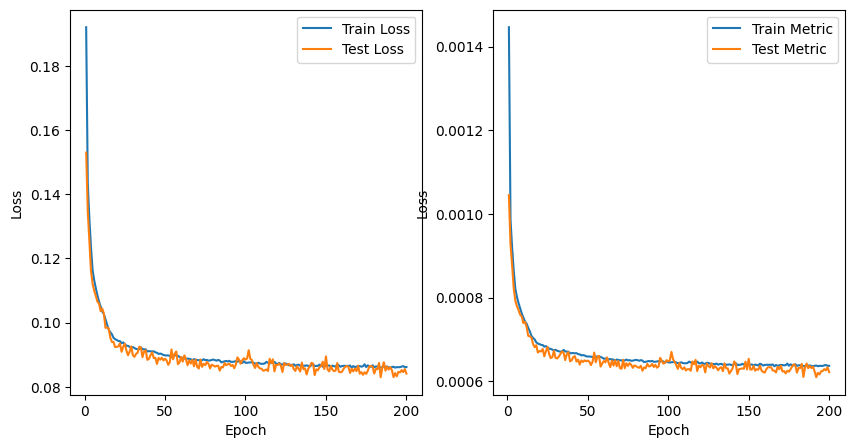

In [96]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label='Train Loss')
plt.plot(range(1, len(test_loss_list)+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_metric_list)+1), train_metric_list, label='Train Metric')
plt.plot(range(1, len(test_metric_list)+1), test_metric_list, label='Test Metric')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Visualize Clusters

### K-Means with Embedding

/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_73602/2720056154.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('plasma', 10)


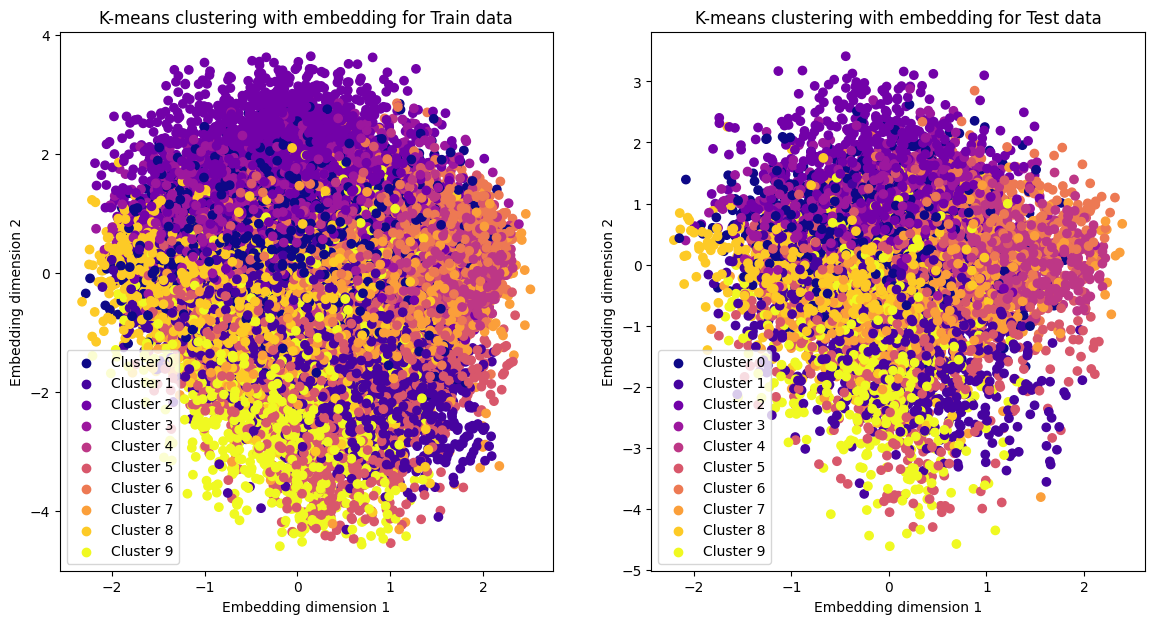

In [97]:
plt.figure(figsize=(14, 7))
colors = plt.cm.get_cmap('plasma', 10)

plt.subplot(1, 2, 1)
cluster_labels = embed_kmeans.labels_
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap=colors, marker='o')
plt.legend(handles=[plt.scatter([],[], color=colors(i), label='Cluster {}'.format(i)) for i in range(10)])
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('K-means clustering with embedding for Train data')
plt.legend()

plt.subplot(1, 2, 2)
cluster_labels = embed_pred_clusters
plt.scatter(test_embeddings[:, 0], test_embeddings[:, 1], c=cluster_labels, cmap=colors, marker='o')
plt.legend(handles=[plt.scatter([],[], color=colors(i), label='Cluster {}'.format(i)) for i in range(10)])
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('K-means clustering with embedding for Test data')
plt.legend()

plt.show()

## Visualize some original and reconstructed images

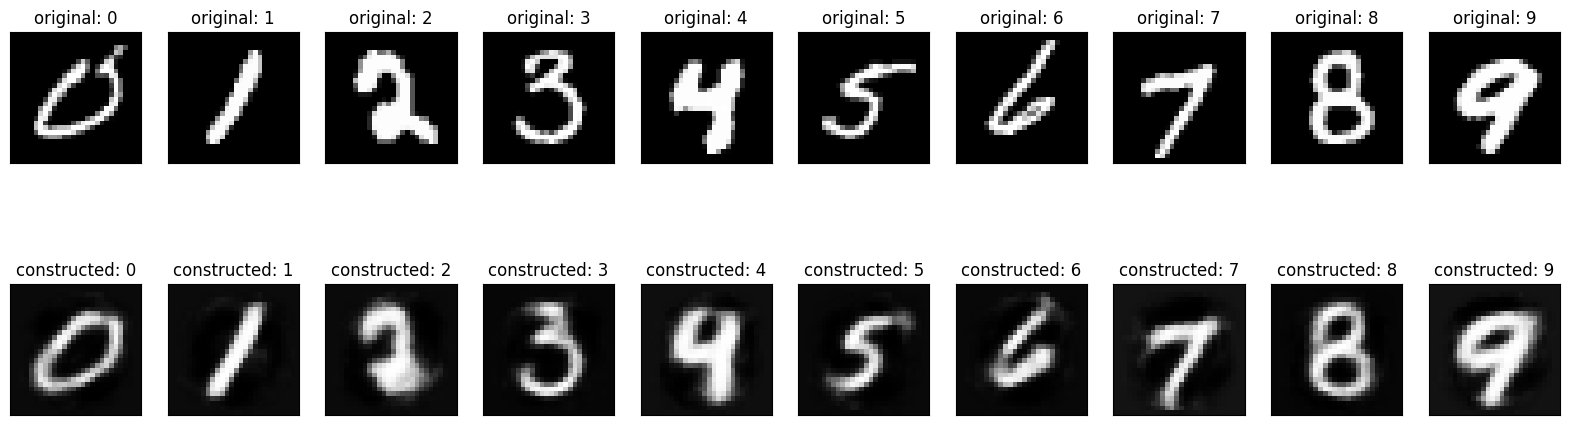

In [98]:
SEED_V = 21

images = capture_images(SEED_V, test_set)
plot_org_constructed_plot(autoencoder, images)

plt.show()

In [99]:
# anim = animation.FuncAnimation(
#     plt.figure(),
#     lambda frame: animation_frames[frame],
#     frames=len(animation_frames),
#     interval=200,
#     repeat=True
# )
#
# writer = animation.PillowWriter(fps=15)
# anim.save('original_reconstructed_animation.gif', writer=writer)

# video = anim.to_html5_video()
# html = display.HTML(video)
# display.display(html)

In [100]:
# Image(url='original_reconstructed_animation.gif')


In [102]:
# as code above doesn't work all the time
from IPython.display import clear_output
from time import sleep

for idx, frame in enumerate(animation_frames, start=1):
    print(f"Frame #{idx}")
    display.display(frame)
    sleep(3)
    clear_output()